<a href="https://colab.research.google.com/github/keeprich/AI-Trading-Bot/blob/main/personal_profit_trade.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install oandapyV20
!pip install pandas
!pip install numpy
!pip install sklearn
!pip install tensorflow
!pip install matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.6/51.6 kB 1.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for oandapyV20: filename=oandapyV20-0.7.2-py3-none-any.whl size=69778 sha256=418b6754178afc970fcd13d868af198be5ad49cf90fdf442a4bd1a7a38c16b0e
  Stored in directory: /root/.cache/pip/wheels/8e/69/ab/a6da84a85b9bf3b5a98ca15c6c52b7854f32b10c70fe0531a1
Successfully built oandapyV20
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.


Epoch 1/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 8s 129ms/step - future_price_loss: 0.0556 - future_price_mae: 0.1878 - loss: 0.8527 - reversal_probability_accuracy: 0.0000e+00 - reversal_probability_loss: 0.6752 - trend_strength_loss: 0.1216 - trend_strength_mae: 0.2706 - val_future_price_loss: 0.0025 - val_future_price_mae: 0.0393 - val_loss: 0.7776 - val_reversal_probability_accuracy: 0.0000e+00 - val_reversal_probability_loss: 0.7643 - val_trend_strength_loss: 0.0099 - val_trend_strength_mae: 0.0915
Epoch 2/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 93ms/step - future_price_loss: 0.0089 - future_price_mae: 0.0723 - loss: 0.6543 - reversal_probability_accuracy: 0.0000e+00 - reversal_probability_loss: 0.6318 - trend_strength_loss: 0.0134 - trend_strength_mae: 0.0905 - val_future_price_loss: 0.0060 - val_future_price_mae: 0.0664 - val_loss: 0.7173 - val_reversal_probability_accuracy: 0.0000e+00 - val_reversal_probability_loss: 0.7088 - val_trend_strength_loss: 0.0020 - val_trend_strength_mae: 0.0356
Epoch

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step


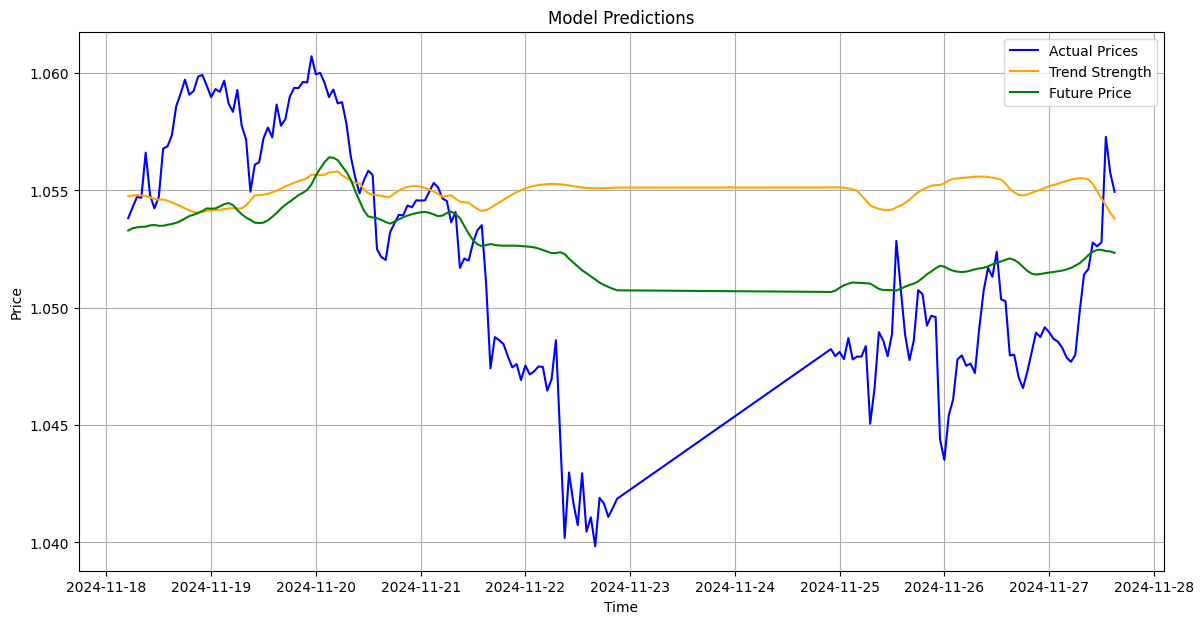

In [4]:
import oandapyV20
import oandapyV20.endpoints.instruments as instruments
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout
from datetime import datetime, timedelta
import matplotlib.pyplot as plt

# OANDA API Credentials
ACCESS_TOKEN = "c18f86851d4bc0df6484465cc421b291-0cfa37fe32e0bd236d25613eb716b95e"
ACCOUNT_ID = "101-004-30239848-002"
client = oandapyV20.API(access_token=ACCESS_TOKEN)

# Constants
SEQUENCE_LENGTH = 60
FEATURE_COLUMNS = ['close', 'RSI', 'SMA_50', 'EMA_50', 'BB_Mid', 'BB_Upper', 'BB_Lower']
START_DATE = "2022-01-01"
GRANULARITY = "H1"

# Fetch Historical Data
def fetch_oanda_data(instrument="EUR_USD", granularity="M1", count=500):
    params = {"granularity": granularity, "count": count}
    try:
        endpoint = instruments.InstrumentsCandles(instrument=instrument, params=params)
        client.request(endpoint)
        candles = endpoint.response["candles"]

        records = []
        for candle in candles:
            records.append({
                "time": candle["time"],
                "open": float(candle["mid"]["o"]),
                "high": float(candle["mid"]["h"]),
                "low": float(candle["mid"]["l"]),
                "close": float(candle["mid"]["c"]),
            })

        df = pd.DataFrame(records)
        df["time"] = pd.to_datetime(df["time"])
        return df
    except Exception as e:
        print(f"Error fetching data for {instrument}: {e}")
        return pd.DataFrame()

# Calculate Indicators
def calculate_rsi(prices, period=14):
    delta = prices.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=period).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=period).mean()
    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

def calculate_sma(prices, window):
    return prices.rolling(window=window).mean()

def calculate_ema(prices, window):
    return prices.ewm(span=window, adjust=False).mean()

def calculate_bollinger_bands(prices, window=20):
    sma = prices.rolling(window=window).mean()
    std = prices.rolling(window=window).std()
    upper_band = sma + (2 * std)
    lower_band = sma - (2 * std)
    return sma, upper_band, lower_band

# Preprocess Data
def preprocess_data(data, target_columns, sequence_length=SEQUENCE_LENGTH):
    if data.empty:
        raise ValueError("Dataset is empty. Cannot preprocess.")

    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(data)

    X, y = [], []
    for i in range(sequence_length, len(scaled_data)):
        X.append(scaled_data[i-sequence_length:i])  # Features
        y.append(scaled_data[i, target_columns])   # Targets
    return np.array(X), np.array(y), scaler

# Build LSTM Model
def build_extended_model(input_shape):
    inputs = Input(shape=input_shape)
    x = LSTM(64, return_sequences=True)(inputs)
    x = Dropout(0.2)(x)
    x = LSTM(64, return_sequences=False)(x)
    x = Dropout(0.2)(x)
    shared = Dense(32, activation='relu')(x)

    # Output 1: Trend Strength
    trend_output = Dense(1, activation='linear', name='trend_strength')(shared)

    # Output 2: Reversal Probability
    reversal_output = Dense(1, activation='sigmoid', name='reversal_probability')(shared)

    # Output 3: Future Price
    future_price_output = Dense(1, activation='linear', name='future_price')(shared)

    model = Model(inputs=inputs, outputs=[trend_output, reversal_output, future_price_output])
    model.compile(optimizer='adam',
                  loss={
                      'trend_strength': 'mean_squared_error',
                      'reversal_probability': 'binary_crossentropy',
                      'future_price': 'mean_squared_error'
                  },
                  metrics={
                      'trend_strength': 'mae',
                      'reversal_probability': 'accuracy',
                      'future_price': 'mae'
                  })
    return model

# Visualize Results
def plot_results(data, predictions, title="Model Predictions"):
    plt.figure(figsize=(14, 7))
    plt.plot(data['time'], data['close'], label="Actual Prices", color="blue")
    plt.plot(data['time'], predictions['trend_strength'], label="Trend Strength", color="orange")
    plt.plot(data['time'], predictions['future_price'], label="Future Price", color="green")
    plt.title(title)
    plt.xlabel("Time")
    plt.ylabel("Price")
    plt.legend()
    plt.grid(True)
    plt.show()

# Main Workflow
if __name__ == "__main__":
    # Fetch data from OANDA
    data = fetch_oanda_data(instrument="EUR_USD", granularity=GRANULARITY, count=1000)

    if data.empty:
        print("No data fetched. Exiting.")
    else:
        # Calculate indicators
        data['RSI'] = calculate_rsi(data['close'])
        data['SMA_50'] = calculate_sma(data['close'], window=50)
        data['EMA_50'] = calculate_ema(data['close'], window=50)
        data['BB_Mid'], data['BB_Upper'], data['BB_Lower'] = calculate_bollinger_bands(data['close'])

        # Drop NaN values
        data.dropna(inplace=True)

        # Prepare features and target columns
        feature_columns = FEATURE_COLUMNS
        target_columns = [0]  # Target is close price (you can extend as needed)
        X, y, scaler = preprocess_data(data[feature_columns], target_columns)

        # Split data
        split = int(0.8 * len(X))
        X_train, X_test = X[:split], X[split:]
        y_train, y_test = y[:split], y[split:]

        # Train the model
        model = build_extended_model(input_shape=(X_train.shape[1], X_train.shape[2]))
        model.fit(X_train, [y_train, y_train, y_train], epochs=20, batch_size=32, validation_data=(X_test, [y_test, y_test, y_test]))

        # Save the model
        model.save("multi_output_lstm_model.h5")

        # Make predictions
        predictions = model.predict(X_test)

# ... (previous code) ...

# Rescale predictions
        trend_strength = scaler.inverse_transform(np.repeat(predictions[0], len(FEATURE_COLUMNS), axis=1))[:, 0]  # Reshape to match original features
        future_price = scaler.inverse_transform(np.repeat(predictions[2], len(FEATURE_COLUMNS), axis=1))[:, 0]  # Reshape to match original features

# Visualize
        plot_results(data.iloc[-len(X_test):], {'trend_strength': trend_strength, 'future_price': future_price})


13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step


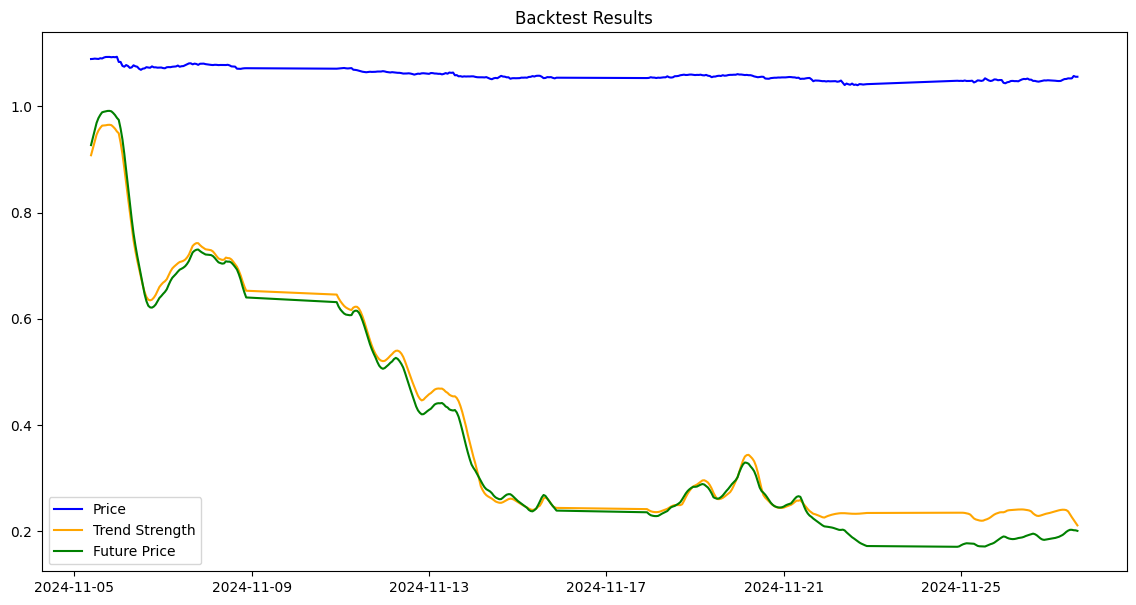

In [7]:
import oandapyV20
import oandapyV20.endpoints.instruments as instruments
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout
import time
import matplotlib.pyplot as plt

# OANDA API Credentials
ACCESS_TOKEN = "c18f86851d4bc0df6484465cc421b291-0cfa37fe32e0bd236d25613eb716b95e"
ACCOUNT_ID = "101-004-30239848-002"
client = oandapyV20.API(access_token=ACCESS_TOKEN)


# Constants
SEQUENCE_LENGTH = 60
FEATURE_COLUMNS = ['close', 'RSI', 'SMA_50', 'EMA_50', 'BB_Mid', 'BB_Upper', 'BB_Lower']
START_DATE = "2022-01-01"
GRANULARITY = "H1"

# Fetch Historical Data
def fetch_oanda_data(instrument="EUR_USD", granularity="H1", count=500):
    params = {"granularity": granularity, "count": count}
    try:
        endpoint = instruments.InstrumentsCandles(instrument=instrument, params=params)
        client.request(endpoint)
        candles = endpoint.response["candles"]

        records = []
        for candle in candles:
            records.append({
                "time": candle["time"],
                "open": float(candle["mid"]["o"]),
                "high": float(candle["mid"]["h"]),
                "low": float(candle["mid"]["l"]),
                "close": float(candle["mid"]["c"]),
            })

        df = pd.DataFrame(records)
        df["time"] = pd.to_datetime(df["time"])
        return df
    except Exception as e:
        print(f"Error fetching data for {instrument}: {e}")
        return pd.DataFrame()

# Calculate Indicators
def calculate_rsi(prices, period=14):
    delta = prices.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=period).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=period).mean()
    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

def calculate_sma(prices, window):
    return prices.rolling(window=window).mean()

def calculate_ema(prices, window):
    return prices.ewm(span=window, adjust=False).mean()

def calculate_bollinger_bands(prices, window=20):
    sma = prices.rolling(window=window).mean()
    std = prices.rolling(window=window).std()
    upper_band = sma + (2 * std)
    lower_band = sma - (2 * std)
    return sma, upper_band, lower_band

# Preprocess Data
def preprocess_data(data, target_columns, sequence_length=SEQUENCE_LENGTH):
    if data.empty:
        raise ValueError("Dataset is empty. Cannot preprocess.")

    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(data)

    X, y = [], []
    for i in range(sequence_length, len(scaled_data)):
        X.append(scaled_data[i-sequence_length:i])  # Features
        y.append(scaled_data[i, target_columns])   # Targets
    return np.array(X), np.array(y), scaler

# Build LSTM Model
def build_extended_model(input_shape):
    inputs = Input(shape=input_shape)
    x = LSTM(64, return_sequences=True)(inputs)
    x = Dropout(0.2)(x)
    x = LSTM(64, return_sequences=False)(x)
    x = Dropout(0.2)(x)
    shared = Dense(32, activation='relu')(x)

    # Output 1: Trend Strength
    trend_output = Dense(1, activation='linear', name='trend_strength')(shared)

    # Output 2: Reversal Probability
    reversal_output = Dense(1, activation='sigmoid', name='reversal_probability')(shared)

    # Output 3: Future Price
    future_price_output = Dense(1, activation='linear', name='future_price')(shared)

    model = Model(inputs=inputs, outputs=[trend_output, reversal_output, future_price_output])
    model.compile(optimizer='adam',
                  loss={
                      'trend_strength': 'mean_squared_error',
                      'reversal_probability': 'binary_crossentropy',
                      'future_price': 'mean_squared_error'
                  },
                  metrics={
                      'trend_strength': 'mae',
                      'reversal_probability': 'accuracy',
                      'future_price': 'mae'
                  })
    return model

# Backtesting Strategy
def backtest_strategy():
    data = fetch_oanda_data(instrument="EUR_USD", granularity=GRANULARITY, count=500)
    if data.empty:
        print("No data fetched. Exiting.")
        return

    # Add indicators
    data['RSI'] = calculate_rsi(data['close'])
    data['SMA_50'] = calculate_sma(data['close'], window=50)
    data['EMA_50'] = calculate_ema(data['close'], window=50)
    data['BB_Mid'], data['BB_Upper'], data['BB_Lower'] = calculate_bollinger_bands(data['close'])

    data.dropna(inplace=True)

    feature_columns = FEATURE_COLUMNS
    target_columns = [0]  # Target is close price
    X, y, scaler = preprocess_data(data[feature_columns], target_columns)

    # Load model and predict
    model = load_model("multi_output_lstm_model.h5")
    predictions = model.predict(X)

    trend_strength = predictions[0]
    future_price = predictions[2]

    # Adjust the time index for plotting to match prediction length
    plot_time = data['time'][SEQUENCE_LENGTH:]  # Start from where predictions begin

    # Reshape predictions if needed
    trend_strength = trend_strength.reshape(-1) # Reshape to 1D
    future_price = future_price.reshape(-1)     # Reshape to 1D


    # Visualize the results
    plt.figure(figsize=(14, 7))
    plt.plot(plot_time, data['close'][SEQUENCE_LENGTH:], label="Price", color='blue') # Adjusted time and data
    plt.plot(plot_time, trend_strength, label="Trend Strength", color='orange') # Adjusted time
    plt.plot(plot_time, future_price, label="Future Price", color='green') # Adjusted time
    plt.legend()
    plt.title("Backtest Results")
    plt.show()

if __name__ == "__main__":
    backtest_strategy()


Model loaded successfully!


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 310ms/step
Predicted Trend: [1.0631648], Action: Buy
Error in live trading loop: x and y must have same first dimension, but have shapes (111,) and (1, 1)


KeyboardInterrupt: 

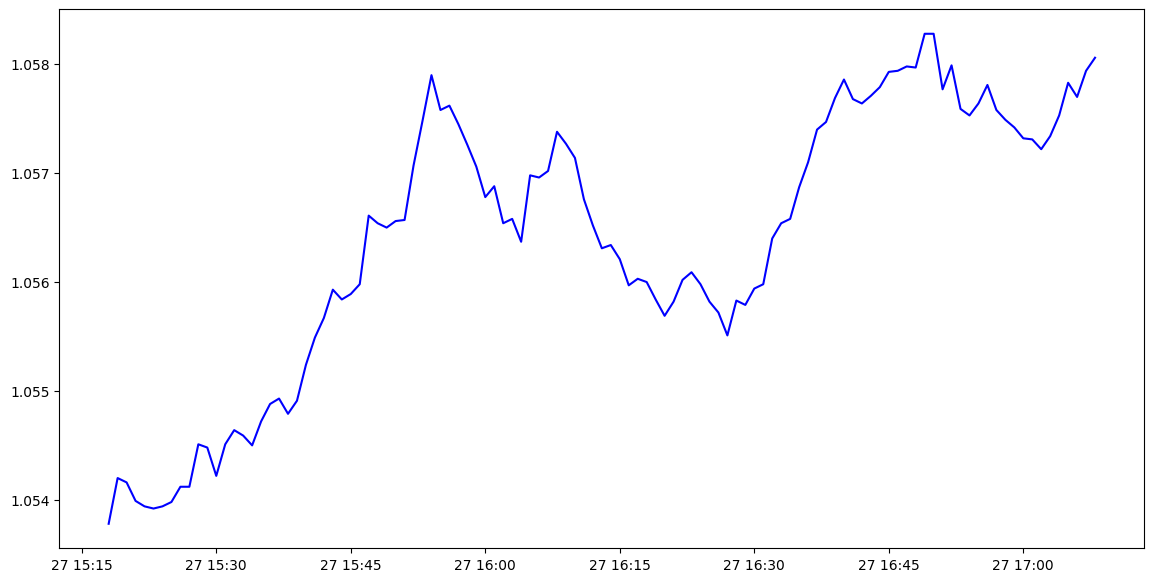

In [11]:
import oandapyV20
import oandapyV20.endpoints.instruments as instruments
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import load_model
import time
import matplotlib.pyplot as plt
from datetime import datetime

# OANDA API Credentials
ACCESS_TOKEN = "c18f86851d4bc0df6484465cc421b291-0cfa37fe32e0bd236d25613eb716b95e"
ACCOUNT_ID = "101-004-30239848-002"
client = oandapyV20.API(access_token=ACCESS_TOKEN)

# Constants
SEQUENCE_LENGTH = 60
FEATURE_COLUMNS = ['close', 'RSI', 'SMA_50', 'EMA_50', 'BB_Mid', 'BB_Upper', 'BB_Lower']
GRANULARITY = "H1"
TRADE_INTERVAL = 60  # In seconds (1 minute interval)

# Fetch Historical Data from OANDA
def fetch_oanda_data(instrument="EUR_USD", granularity="H1", count=500):
    params = {"granularity": granularity, "count": count}
    try:
        endpoint = instruments.InstrumentsCandles(instrument=instrument, params=params)
        client.request(endpoint)
        candles = endpoint.response["candles"]

        records = []
        for candle in candles:
            records.append({
                "time": candle["time"],
                "open": float(candle["mid"]["o"]),
                "high": float(candle["mid"]["h"]),
                "low": float(candle["mid"]["l"]),
                "close": float(candle["mid"]["c"]),
            })

        df = pd.DataFrame(records)
        df["time"] = pd.to_datetime(df["time"])
        return df
    except Exception as e:
        print(f"Error fetching data for {instrument}: {e}")
        return pd.DataFrame()

# Calculate Indicators
def calculate_rsi(prices, period=14):
    delta = prices.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=period).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=period).mean()
    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

def calculate_sma(prices, window):
    return prices.rolling(window=window).mean()

def calculate_ema(prices, window):
    return prices.ewm(span=window, adjust=False).mean()

def calculate_bollinger_bands(prices, window=20):
    sma = prices.rolling(window=window).mean()
    std = prices.rolling(window=window).std()
    upper_band = sma + (2 * std)
    lower_band = sma - (2 * std)
    return sma, upper_band, lower_band

# Preprocess Data
def preprocess_data(data, target_columns, sequence_length=SEQUENCE_LENGTH):
    if data.empty:
        raise ValueError("Dataset is empty. Cannot preprocess.")

    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(data)

    X, y = [], []
    for i in range(sequence_length, len(scaled_data)):
        X.append(scaled_data[i-sequence_length:i])  # Features
        y.append(scaled_data[i, target_columns])   # Targets
    return np.array(X), np.array(y), scaler

# Build LSTM Model
def build_extended_model(input_shape):
    from tensorflow.keras.layers import Input, LSTM, Dense, Dropout
    from tensorflow.keras.models import Model

    inputs = Input(shape=input_shape)
    x = LSTM(64, return_sequences=True)(inputs)
    x = Dropout(0.2)(x)
    x = LSTM(64, return_sequences=False)(x)
    x = Dropout(0.2)(x)
    shared = Dense(32, activation='relu')(x)

    # Output 1: Trend Strength
    trend_output = Dense(1, activation='linear', name='trend_strength')(shared)

    # Output 2: Reversal Probability
    reversal_output = Dense(1, activation='sigmoid', name='reversal_probability')(shared)

    # Output 3: Future Price
    future_price_output = Dense(1, activation='linear', name='future_price')(shared)

    model = Model(inputs=inputs, outputs=[trend_output, reversal_output, future_price_output])
    model.compile(optimizer='adam',
                  loss={
                      'trend_strength': 'mean_squared_error',
                      'reversal_probability': 'binary_crossentropy',
                      'future_price': 'mean_squared_error'
                  },
                  metrics={
                      'trend_strength': 'mae',
                      'reversal_probability': 'accuracy',
                      'future_price': 'mae'
                  })
    return model

# Load Model
def load_or_train_model():
    try:
        model = load_model("multi_output_lstm_model.h5")
        print("Model loaded successfully!")
    except:
        print("No model found, training new model...")
        data = fetch_oanda_data(instrument="EUR_USD", granularity=GRANULARITY, count=1000)
        if data.empty:
            print("No data fetched for training. Exiting.")
            return None

        # Add indicators and preprocess
        data['RSI'] = calculate_rsi(data['close'])
        data['SMA_50'] = calculate_sma(data['close'], window=50)
        data['EMA_50'] = calculate_ema(data['close'], window=50)
        data['BB_Mid'], data['BB_Upper'], data['BB_Lower'] = calculate_bollinger_bands(data['close'])

        # Drop NaN values
        data.dropna(inplace=True)

        # Prepare features and target columns
        feature_columns = ['close', 'RSI', 'SMA_50', 'EMA_50', 'BB_Mid', 'BB_Upper', 'BB_Lower']
        target_columns = [0]  # Target is close price
        X, y, scaler = preprocess_data(data[feature_columns], target_columns)

        # Train the model
        model = build_extended_model(input_shape=(X.shape[1], X.shape[2]))
        model.fit(X, [y, y, y], epochs=20, batch_size=32)

        # Save the model
        model.save("multi_output_lstm_model.h5")
        print("Model trained and saved.")
    return model

# Visualize Results
def plot_results(data, predictions, title="Model Predictions"):
    plt.figure(figsize=(14, 7))
    plt.plot(data['time'], data['close'], label="Actual Prices", color="blue")
    plt.plot(data['time'], predictions['trend_strength'], label="Trend Strength", color="orange")
    plt.plot(data['time'], predictions['future_price'], label="Future Price", color="green")
    plt.title(title)
    plt.xlabel("Time")
    plt.ylabel("Price")
    plt.legend()
    plt.grid(True)
    plt.show()

# Live Trading Logic
def live_trading():
    predicted_trends = []  # List to keep track of predicted trends

    while True:
        try:
            # Fetch live data from OANDA
            live_data = fetch_oanda_data(instrument="EUR_USD", granularity="M1", count=SEQUENCE_LENGTH + 100)
            if live_data.empty or len(live_data) < SEQUENCE_LENGTH + 100:
                print("Insufficient live data. Skipping this cycle.")
                time.sleep(TRADE_INTERVAL)
                continue

            # Calculate indicators for live data
            live_data['RSI'] = calculate_rsi(live_data['close'])
            live_data['SMA_50'] = calculate_sma(live_data['close'], window=50)
            live_data['EMA_50'] = calculate_ema(live_data['close'], window=50)
            live_data['BB_Mid'], live_data['BB_Upper'], live_data['BB_Lower'] = calculate_bollinger_bands(live_data['close'])

            # Drop NaN values caused by indicators
            live_data.dropna(inplace=True)

            # Prepare model input
            input_data = live_data[FEATURE_COLUMNS].values[-SEQUENCE_LENGTH:]
            input_data = input_data.reshape(1, SEQUENCE_LENGTH, len(FEATURE_COLUMNS))

            # Load model and predict
            model = load_or_train_model()
            if model is None:
                break

            predictions = model.predict(input_data)

            # Append predictions to track the trend
            predicted_trends.append(predictions[0][0])  # Trend strength prediction
            predicted_trends = predicted_trends[-SEQUENCE_LENGTH:]  # Keep the last N predictions

            # Determine action based on predicted trend
            action = "Hold"
            if predictions[0][0] > 0.6:
                action = "Buy"
            elif predictions[0][0] < 0.4:
                action = "Sell"

            print(f"Predicted Trend: {predictions[0][0]}, Action: {action}")

            # Visualize data and predictions
            plot_results(live_data, {'trend_strength': predicted_trends, 'future_price': predictions[2]})

        except Exception as e:
            print(f"Error in live trading loop: {e}")

        # Wait for the next cycle
        time.sleep(TRADE_INTERVAL)

# Main Execution
if __name__ == "__main__":
    live_trading()


In [1]:
import oandapyV20
import oandapyV20.endpoints.instruments as instruments
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import load_model
import time
import matplotlib.pyplot as plt
from datetime import datetime

# OANDA API Credentials
ACCESS_TOKEN = "c18f86851d4bc0df6484465cc421b291-0cfa37fe32e0bd236d25613eb716b95e"
ACCOUNT_ID = "101-004-30239848-002"
client = oandapyV20.API(access_token=ACCESS_TOKEN)

# Constants
SEQUENCE_LENGTH = 60
FEATURE_COLUMNS = ['close', 'RSI', 'SMA_50', 'EMA_50', 'BB_Mid', 'BB_Upper', 'BB_Lower']
GRANULARITY = "H1"
TRADE_INTERVAL = 60  # In seconds (1 minute interval)

# Fetch Historical Data from OANDA
def fetch_oanda_data(instrument="EUR_USD", granularity="H1", count=500):
    params = {"granularity": granularity, "count": count}
    try:
        endpoint = instruments.InstrumentsCandles(instrument=instrument, params=params)
        client.request(endpoint)
        candles = endpoint.response["candles"]

        records = []
        for candle in candles:
            records.append({
                "time": candle["time"],
                "open": float(candle["mid"]["o"]),
                "high": float(candle["mid"]["h"]),
                "low": float(candle["mid"]["l"]),
                "close": float(candle["mid"]["c"]),
            })

        df = pd.DataFrame(records)
        df["time"] = pd.to_datetime(df["time"])
        return df
    except Exception as e:
        print(f"Error fetching data for {instrument}: {e}")
        return pd.DataFrame()

# Calculate Indicators
def calculate_rsi(prices, period=14):
    delta = prices.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=period).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=period).mean()
    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

def calculate_sma(prices, window):
    return prices.rolling(window=window).mean()

def calculate_ema(prices, window):
    return prices.ewm(span=window, adjust=False).mean()

def calculate_bollinger_bands(prices, window=20):
    sma = prices.rolling(window=window).mean()
    std = prices.rolling(window=window).std()
    upper_band = sma + (2 * std)
    lower_band = sma - (2 * std)
    return sma, upper_band, lower_band

# Preprocess Data
def preprocess_data(data, target_columns, sequence_length=SEQUENCE_LENGTH):
    if data.empty:
        raise ValueError("Dataset is empty. Cannot preprocess.")

    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(data)

    X, y = [], []
    for i in range(sequence_length, len(scaled_data)):
        X.append(scaled_data[i-sequence_length:i])  # Features
        y.append(scaled_data[i, target_columns])   # Targets
    return np.array(X), np.array(y), scaler

# Build LSTM Model
def build_extended_model(input_shape):
    from tensorflow.keras.layers import Input, LSTM, Dense, Dropout
    from tensorflow.keras.models import Model

    inputs = Input(shape=input_shape)
    x = LSTM(64, return_sequences=True)(inputs)
    x = Dropout(0.2)(x)
    x = LSTM(64, return_sequences=False)(x)
    x = Dropout(0.2)(x)
    shared = Dense(32, activation='relu')(x)

    # Output 1: Trend Strength
    trend_output = Dense(1, activation='linear', name='trend_strength')(shared)

    # Output 2: Reversal Probability
    reversal_output = Dense(1, activation='sigmoid', name='reversal_probability')(shared)

    # Output 3: Future Price
    future_price_output = Dense(1, activation='linear', name='future_price')(shared)

    model = Model(inputs=inputs, outputs=[trend_output, reversal_output, future_price_output])
    model.compile(optimizer='adam',
                  loss={
                      'trend_strength': 'mean_squared_error',
                      'reversal_probability': 'binary_crossentropy',
                      'future_price': 'mean_squared_error'
                  },
                  metrics={
                      'trend_strength': 'mae',
                      'reversal_probability': 'accuracy',
                      'future_price': 'mae'
                  })
    return model

# Load Model
def load_or_train_model():
    try:
        model = load_model("multi_output_lstm_model.h5")
        print("Model loaded successfully!")
    except:
        print("No model found, training new model...")
        data = fetch_oanda_data(instrument="EUR_USD", granularity=GRANULARITY, count=1000)
        if data.empty:
            print("No data fetched for training. Exiting.")
            return None

        # Add indicators and preprocess
        data['RSI'] = calculate_rsi(data['close'])
        data['SMA_50'] = calculate_sma(data['close'], window=50)
        data['EMA_50'] = calculate_ema(data['close'], window=50)
        data['BB_Mid'], data['BB_Upper'], data['BB_Lower'] = calculate_bollinger_bands(data['close'])

        # Drop NaN values
        data.dropna(inplace=True)

        # Prepare features and target columns
        feature_columns = ['close', 'RSI', 'SMA_50', 'EMA_50', 'BB_Mid', 'BB_Upper', 'BB_Lower']
        target_columns = [0]  # Target is close price
        X, y, scaler = preprocess_data(data[feature_columns], target_columns)

        # Train the model
        model = build_extended_model(input_shape=(X.shape[1], X.shape[2]))
        model.fit(X, [y, y, y], epochs=20, batch_size=32)

        # Save the model
        model.save("multi_output_lstm_model.h5")
        print("Model trained and saved.")
    return model

# Visualize Results
def plot_results(data, predictions, title="Model Predictions"):
    plt.figure(figsize=(14, 7))
    plt.plot(data['time'], data['close'], label="Actual Prices", color="blue")
    plt.plot(data['time'], predictions['trend_strength'], label="Trend Strength", color="orange")
    plt.plot(data['time'], predictions['future_price'], label="Future Price", color="green")
    plt.title(title)
    plt.xlabel("Time")
    plt.ylabel("Price")
    plt.legend()
    plt.grid(True)
    plt.show()

# Live Trading Logic
def live_trading():
    predicted_trends = []  # List to keep track of predicted trends

    while True:
        try:
            # Fetch live data from OANDA
            live_data = fetch_oanda_data(instrument="EUR_USD", granularity="M1", count=SEQUENCE_LENGTH + 100)
            if live_data.empty or len(live_data) < SEQUENCE_LENGTH + 100:
                print("Insufficient live data. Skipping this cycle.")
                time.sleep(TRADE_INTERVAL)
                continue

            # Calculate indicators for live data
            live_data['RSI'] = calculate_rsi(live_data['close'])
            live_data['SMA_50'] = calculate_sma(live_data['close'], window=50)
            live_data['EMA_50'] = calculate_ema(live_data['close'], window=50)
            live_data['BB_Mid'], live_data['BB_Upper'], live_data['BB_Lower'] = calculate_bollinger_bands(live_data['close'])

            # Drop NaN values caused by indicators
            live_data.dropna(inplace=True)

            # Prepare model input
            input_data = live_data[FEATURE_COLUMNS].values[-SEQUENCE_LENGTH:]
            input_data = input_data.reshape(1, SEQUENCE_LENGTH, len(FEATURE_COLUMNS))

            # Predict trends using the model
            model = load_or_train_model()
            predictions = model.predict(input_data)

            # Append predictions for visualization
            predicted_trends.append(predictions[0][0])

            # Visualize the data and predictions
            plot_results(live_data, {'trend_strength': predicted_trends, 'future_price': predictions[2]})

        except Exception as e:
            print(f"Error in live trading loop: {e}")

        # Wait for the next cycle
        time.sleep(TRADE_INTERVAL)

# Main Execution
if __name__ == "__main__":
    live_trading()


ModuleNotFoundError: No module named 'oandapyV20'